# Uncorking Insights on Wine Quality

This report explores the use of machine learning models to classify the quality of red Portuguese “Vinho Verde" wines based on chemical properties. Analyzing a dataset of 1,599 wines, I applied and fine-tuned several models, including Logistic Regression, KNN, Random Forest, and Gradient Boosting, to identify which model and features best captured the relationship between wine chemistry (i.e., acidity, sulfur dioxide, alcohol content) and sensory ratings. This study offers a structured, data-driven approach to wine quality assessment, which can assist winemakers in quality control efforts.

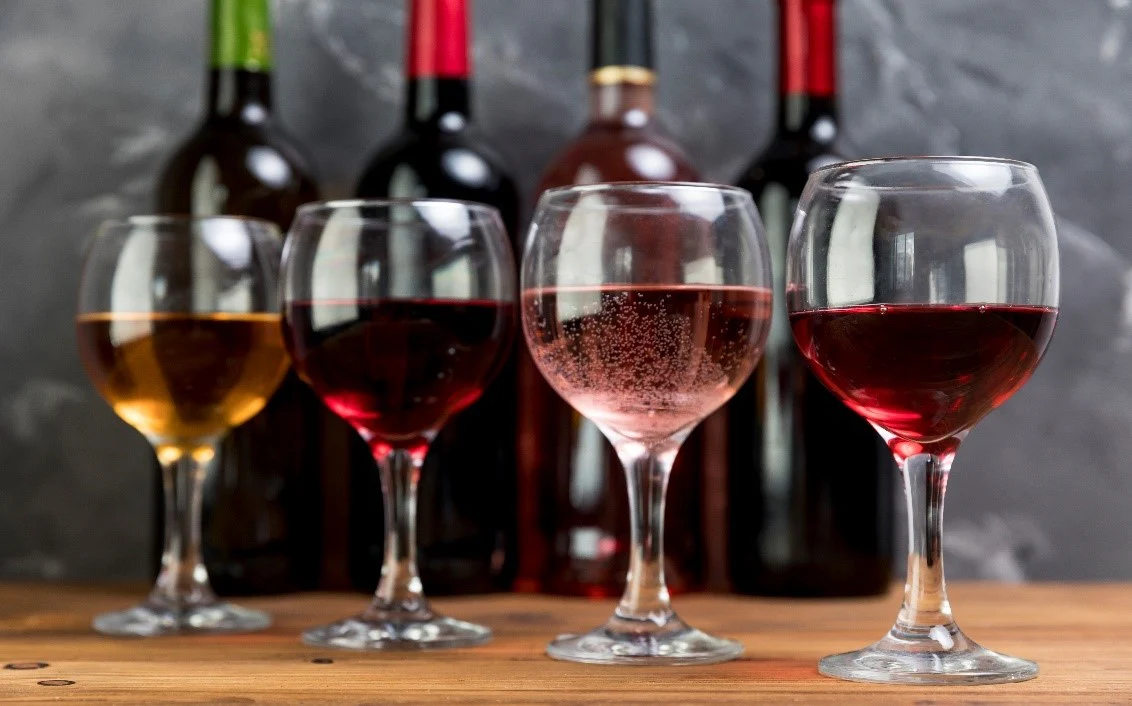
Source: https://www.thinkitchen.in/blogs/latest/types-of-wines

# Import relevant packages

In [1]:
import kagglehub
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import boxcox
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score

c:\Users\karishma\OneDrive\Desktop\AI\GTech\DMSL\A5\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Download dataset

This study uses a dataset sourced from \textit{Modeling Wine Preferences by Data Mining from Physicochemical Properties} by Cortez et al., available on the UCI Machine Learning Repository and Kaggle. While the dataset excludes factors like grape variety, sweetness, and pricing, it enables a focused analysis of wine quality prediction based on chemical properties alone.

In [2]:
path = kagglehub.dataset_download("uciml/red-wine-quality-cortez-et-al-2009")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\karishma\.cache\kagglehub\datasets\uciml\red-wine-quality-cortez-et-al-2009\versions\2


In [3]:
df = pd.read_csv(r'winequality-red.csv')

# EDA

## Examining the loaded data

- **Fixed Acidity**: Non-evaporating acids that give structure.  
- **Volatile Acidity**: Acetic acid level; too much can result in a vinegary taste.  
- **Citric Acid**: Adds a fresh, tart note to wines.  
- **Residual Sugar**: Leftover sugar after fermentation, contributing to sweetness.  
- **Chlorides**: Amount of salt, impacting taste.  
- **Free Sulfur Dioxide**: Prevents oxidation and microbial growth.  
- **Total Sulfur Dioxide**: Combined levels of SO<sub>2</sub>, affecting aroma and stability.  
- **Density**: Related to alcohol and sugar content.  
- **pH**: A measure of acidity; wines typically range between 3–4 on this scale.  
- **Sulphates**: Acts as a preservative and affects SO<sub>2</sub>.   
- **Alcohol**: Alcohol by volume.  
- **Quality**: The sensory rating (0–10) assigned by wine experts, basis for our target variable.

In [4]:
df.shape

(1599, 12)

In [5]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [6]:
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


In [7]:
df.isnull().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

In [8]:
duplicates = df.duplicated().sum()

print(f"Number of duplicates: {duplicates}")

Number of duplicates: 240


## Examining distributions

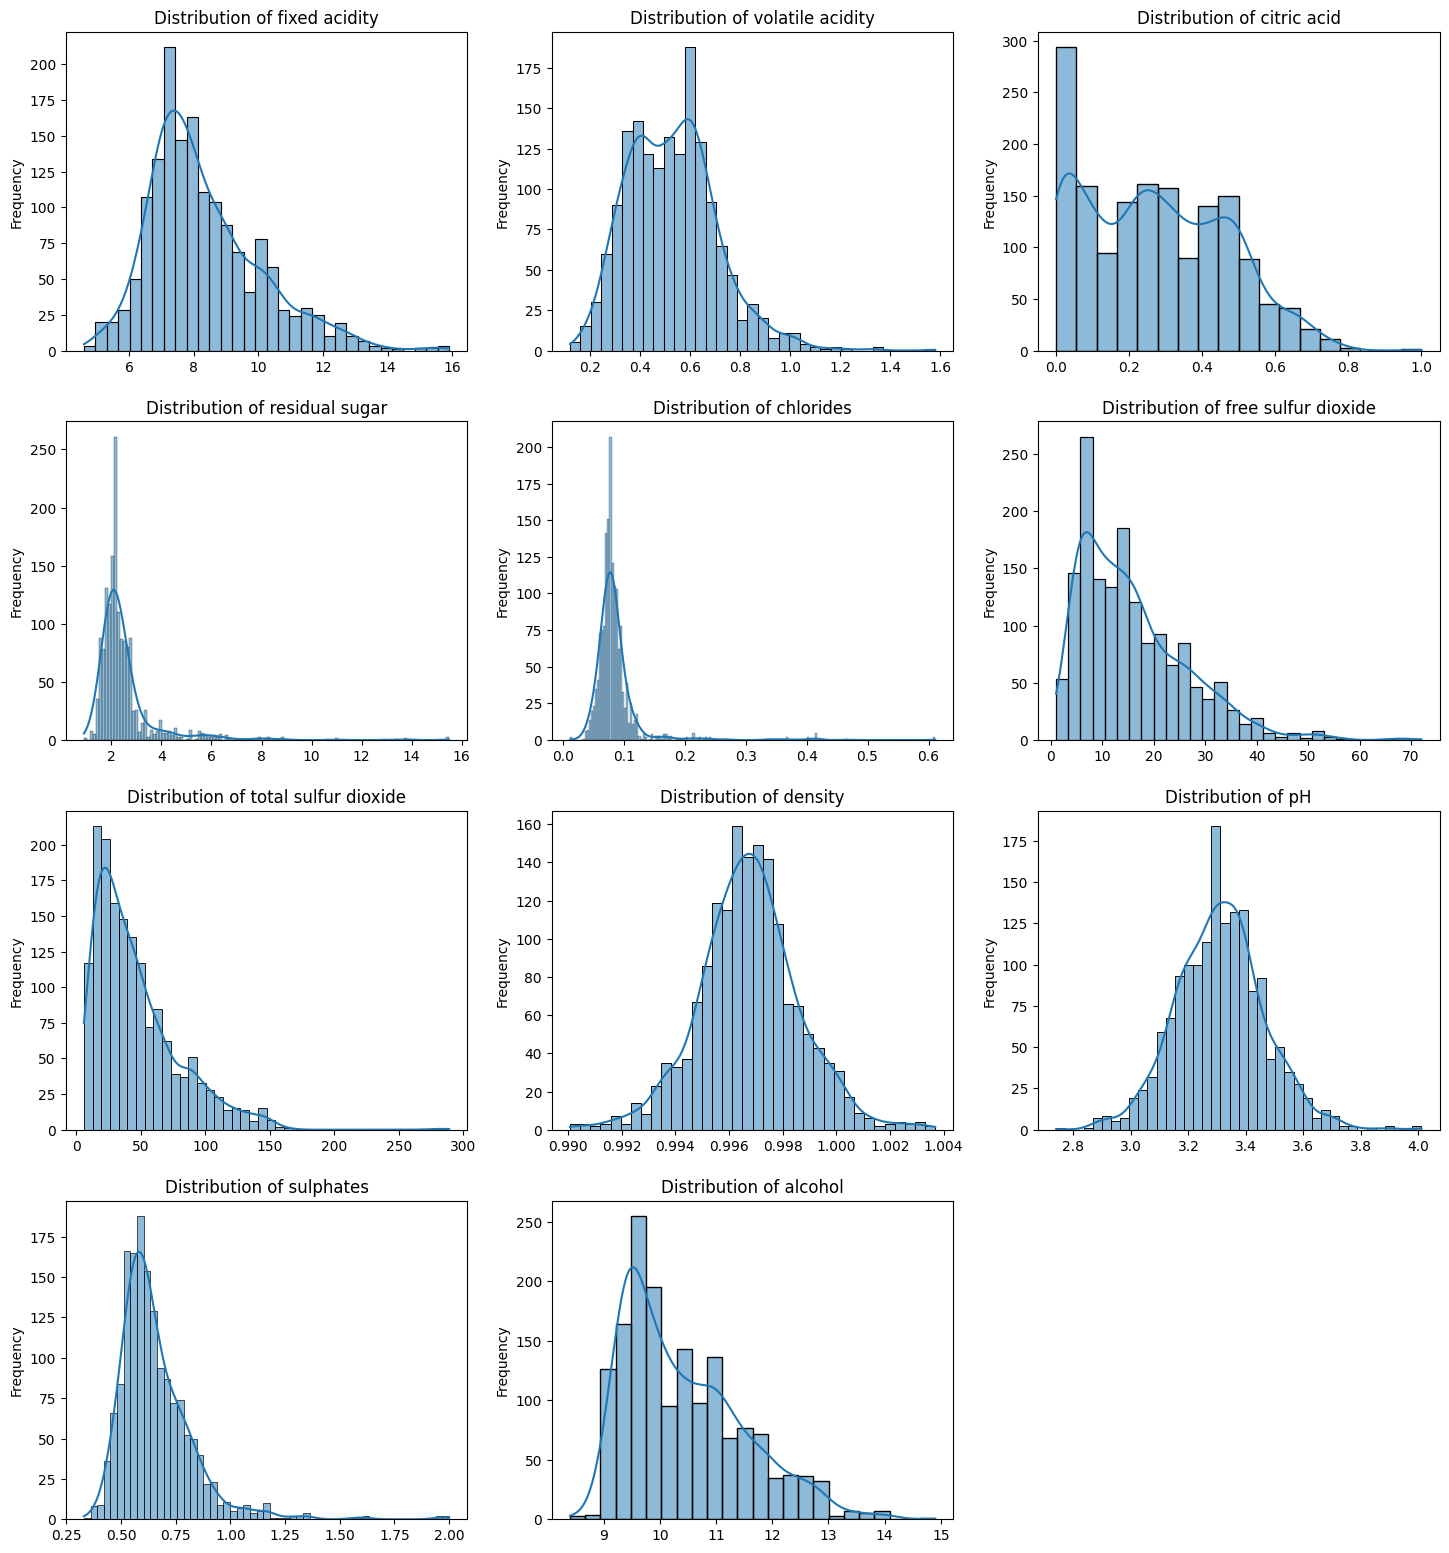

In [9]:
fig, axes = plt.subplots(4, 3, figsize=(15, 16))
fig.tight_layout(pad=3.0)

columns = df.columns.drop('quality')
for i, column in enumerate(columns):
    row, col = divmod(i, 3) 
    sns.histplot(df[column], kde=True, ax=axes[row, col])
    axes[row, col].set_title(f"Distribution of {column}")
    axes[row, col].set_xlabel("")
    axes[row, col].set_ylabel("Frequency")

for j in range(len(columns), 12):
    fig.delaxes(axes[3, j - 9]) 

plt.show()

Exploring the data revealed a mix of distributions (Figure 1), with certain features showing significant skew. For instance, variables like total sulfur dioxide and residual sugar presented long right tails, while others, such as pH and density, showed a more balanced distribution.

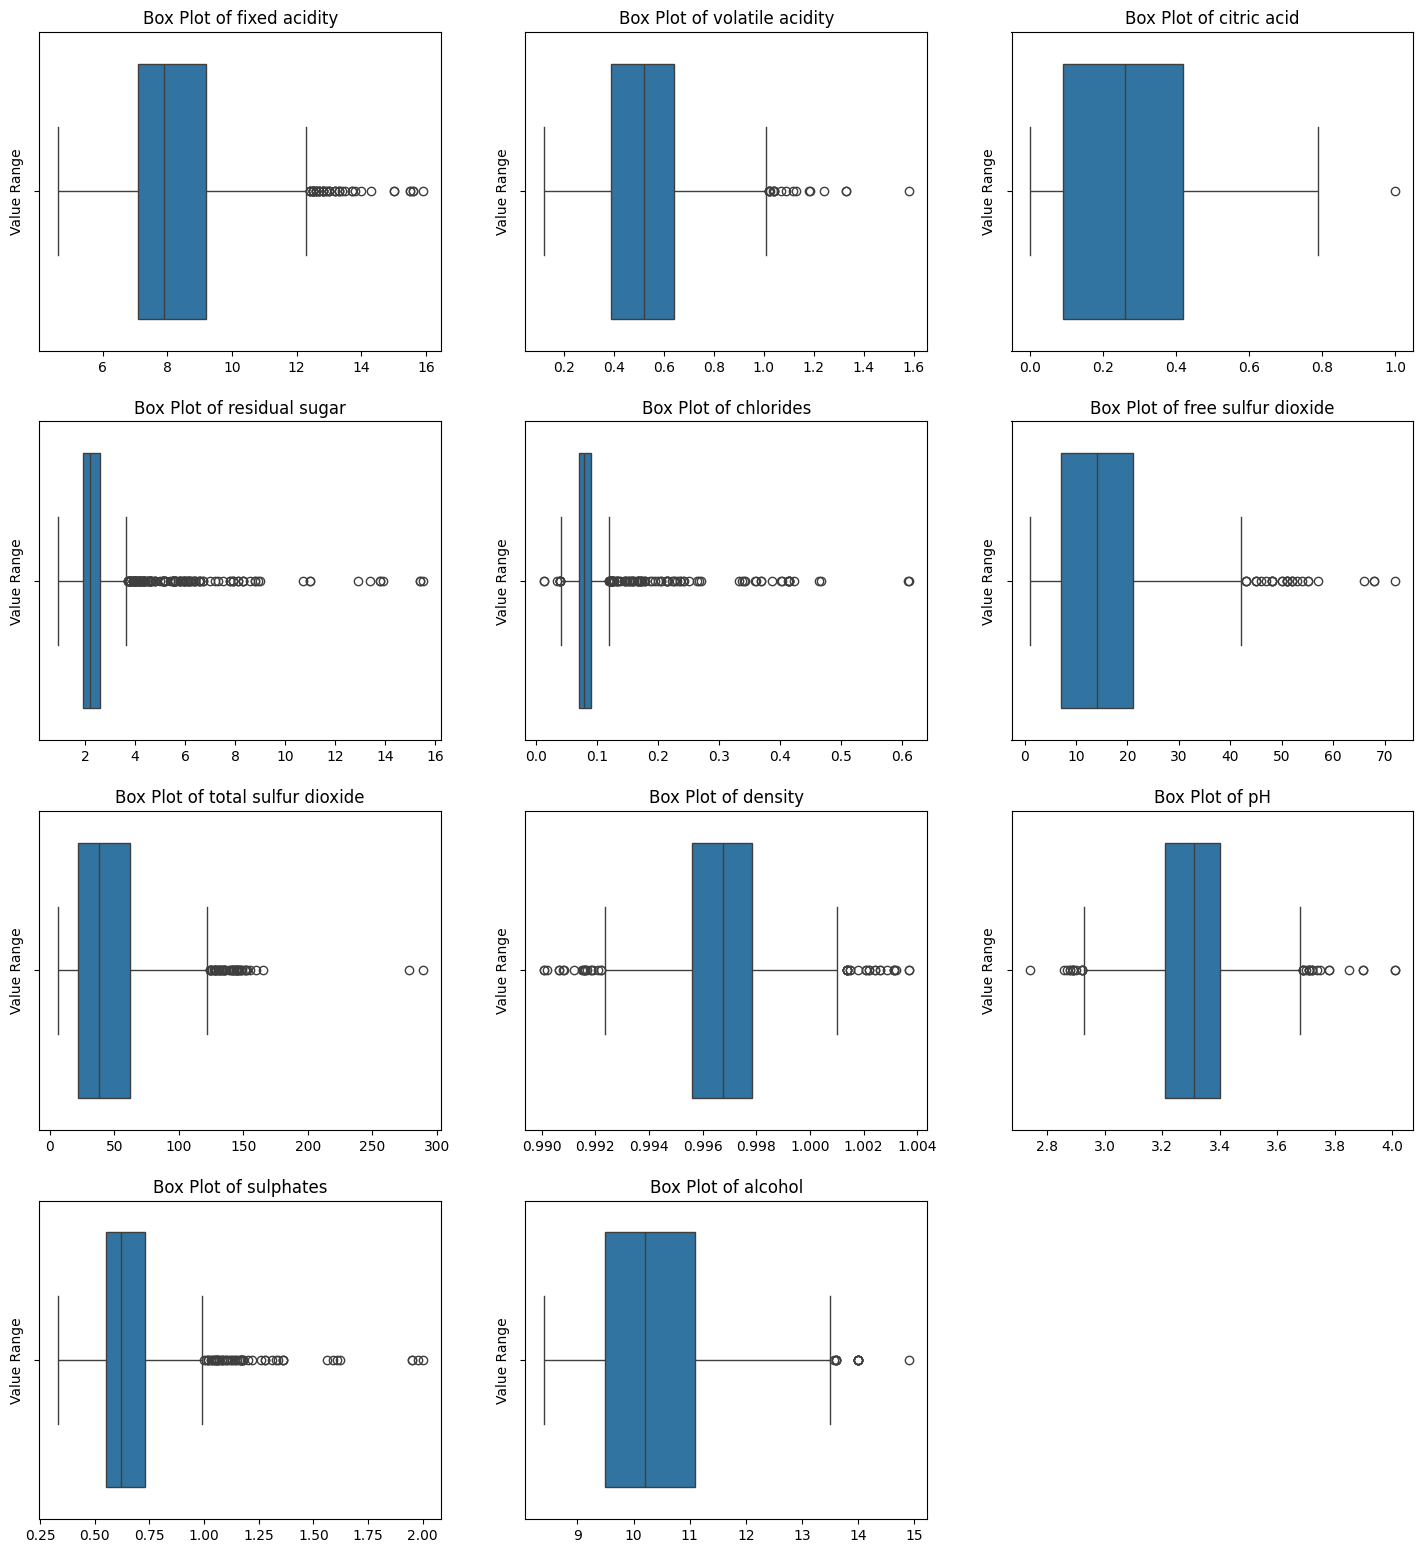

In [10]:
fig, axes = plt.subplots(4, 3, figsize=(15, 16))
fig.tight_layout(pad=3.0)

for i, column in enumerate(df.columns[:-1]):
    row, col = divmod(i, 3) 
    sns.boxplot(data=df, x=column, ax=axes[row, col])
    axes[row, col].set_title(f"Box Plot of {column}")
    axes[row, col].set_xlabel("")
    axes[row, col].set_ylabel("Value Range")

for j in range(len(df.columns) - 1, 12):
    fig.delaxes(axes[j // 3, j % 3])

plt.show()

Several of these distributions technically have outliers but they represent real values for the most part. 

However, it seems total sulfur dioxide has true potential outliers. Questions: 
1) What are the exact values and counts for these and how does this compare to the free sulfur dioxide? i.e., if total sulfur dioxide is high, I would assume free is also be high. 
2) What's the distribution of free sulfur dioxide percent and is it associated with wine quality? 

Several distributions have a right skew. It makes sense to treat for outliers first before normalizing for skewness so the extreme values don't distort subsequent transformations. 

In [11]:
total_sulfur_dioxide_count = df['total sulfur dioxide'].value_counts().sort_values(ascending=False).reset_index()
df['total sulfur dioxide'].value_counts().sort_index(ascending=False)

total sulfur dioxide
289.0     1
278.0     1
165.0     1
160.0     1
155.0     1
         ..
10.0     27
9.0      14
8.0      14
7.0       4
6.0       3
Name: count, Length: 144, dtype: int64

In [12]:
df[df['total sulfur dioxide'] > 150] # for the most part, free sulfur dioxide seems unusually low given the high levels of total sulfur dioxide for these records

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
109,8.1,0.785,0.52,2.0,0.122,37.0,153.0,0.99690,3.21,0.69,9.3,5
354,6.1,0.210,0.40,1.4,0.066,40.5,165.0,0.99120,3.25,0.59,11.9,6
515,8.5,0.655,0.49,6.1,0.122,34.0,151.0,1.00100,3.31,1.14,9.3,5
651,9.8,0.880,0.25,2.5,0.104,35.0,155.0,1.00100,3.41,0.67,11.2,5
672,9.8,1.240,0.34,2.0,0.079,32.0,151.0,0.99800,3.15,0.53,9.5,5
684,9.8,0.980,0.32,2.3,0.078,35.0,152.0,0.99800,3.25,0.48,9.4,5
1079,7.9,0.300,0.68,8.3,0.050,37.5,278.0,0.99316,3.01,0.51,12.3,7
1081,7.9,0.300,0.68,8.3,0.050,37.5,289.0,0.99316,3.01,0.51,12.3,7
1244,5.9,0.290,0.25,13.4,0.067,72.0,160.0,0.99721,3.33,0.54,10.3,6


In [13]:
percentage_high_sulfur = (df[df['total sulfur dioxide'] > 150].shape[0] / df.shape[0]) * 100
print(f"Percentage of data with total sulfur dioxide > 150: {percentage_high_sulfur:.2f}%")

Percentage of data with total sulfur dioxide > 150: 0.56%


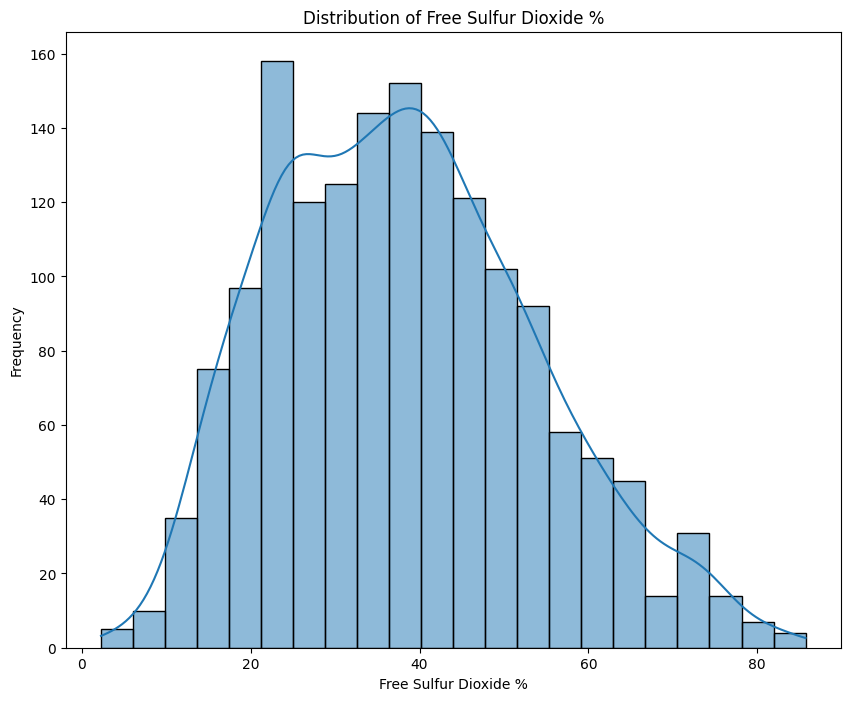

In [14]:
df_sulfur_percent = pd.DataFrame()
df_sulfur_percent['free sulfur dioxide %'] = df['free sulfur dioxide'] / df['total sulfur dioxide'] * 100
df_sulfur_percent['quality'] = df['quality'] 

plt.figure(figsize=(10, 8))
sns.histplot(df_sulfur_percent['free sulfur dioxide %'], kde=True)
plt.title('Distribution of Free Sulfur Dioxide %')
plt.xlabel('Free Sulfur Dioxide %')
plt.ylabel('Frequency')
plt.show()

Upon further research, I realize that red wines typically have a total sulfur dioxide level of 150 ppm (150 mg/litre) or less.

Therefore, I will remove the rows that have a total sulfur dioxide level greater than 150 ppm as these are likely data entry errors and also amount to less than 5% of my data (a small enough portion to not significantly affect the overall dataset).

Source: https://grape-to-glass.com/index.php/sulphur-levels-wine/

In [15]:
df = df[df['total sulfur dioxide'] <= 150].reset_index(drop=True)

print(f"Updated DataFrame shape: {df.shape}")

Updated DataFrame shape: (1590, 12)


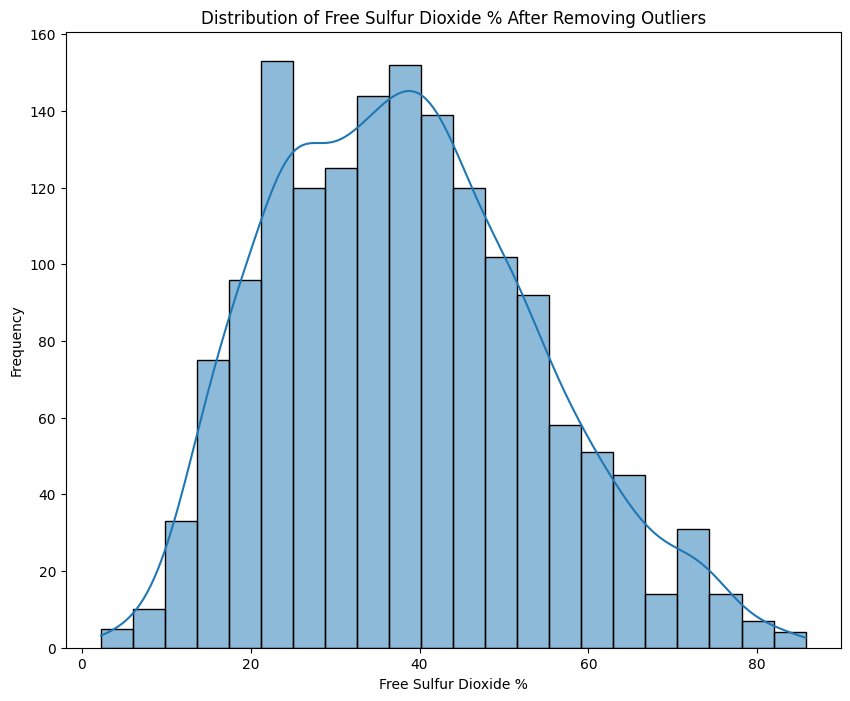

In [16]:
df_sulfur_percent = pd.DataFrame()
df_sulfur_percent['free sulfur dioxide %'] = df['free sulfur dioxide'] / df['total sulfur dioxide'] * 100
df_sulfur_percent['quality'] = df['quality'] 

plt.figure(figsize=(10, 8))
sns.histplot(df_sulfur_percent['free sulfur dioxide %'], kde=True)
plt.title('Distribution of Free Sulfur Dioxide % After Removing Outliers')
plt.xlabel('Free Sulfur Dioxide %')
plt.ylabel('Frequency')
plt.show()

# Data remains relatively unchanged after removing rows with total sulfur dioxide > 150

C:\Users\karishma\AppData\Local\Temp\ipykernel_39048\1566668519.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_sulfur_percent, x='quality', y='free sulfur dioxide %', palette='PuBuGn')


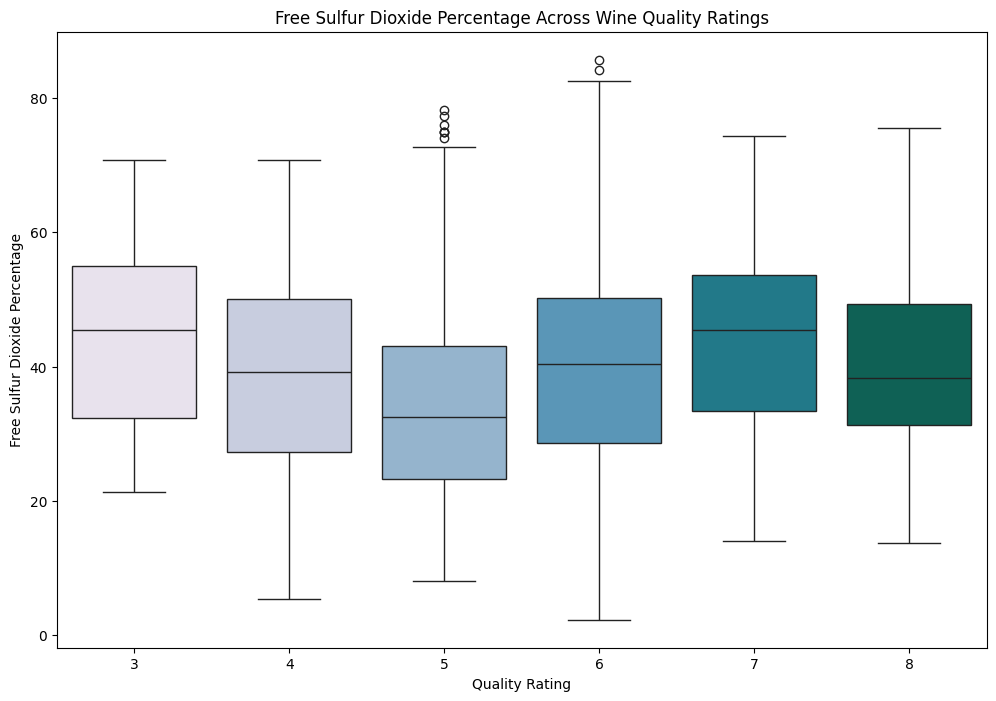

In [17]:
plt.figure(figsize=(12, 8))
sns.boxplot(data=df_sulfur_percent, x='quality', y='free sulfur dioxide %', palette='PuBuGn')
plt.title("Free Sulfur Dioxide Percentage Across Wine Quality Ratings")
plt.xlabel("Quality Rating")
plt.ylabel("Free Sulfur Dioxide Percentage")
plt.show()

# Free sulfur dioxide percentage doesn't seem to have a significant impact on wine quality.
# Including a new variable with this information will likely not be meaningful for our model. 

## Normalizing the data

I'm using Box-Cox to normalize the data as it provides a more tailored transformation to suit the data's unique skewness. Log transformations, in comparison, are limited in their ability to address skewness comprehensively. 

In [18]:
skewed_columns = ['fixed acidity', 'volatile acidity', 'residual sugar', 'chlorides', 'free sulfur dioxide', 
                  'total sulfur dioxide', 'sulphates', 'alcohol'] 

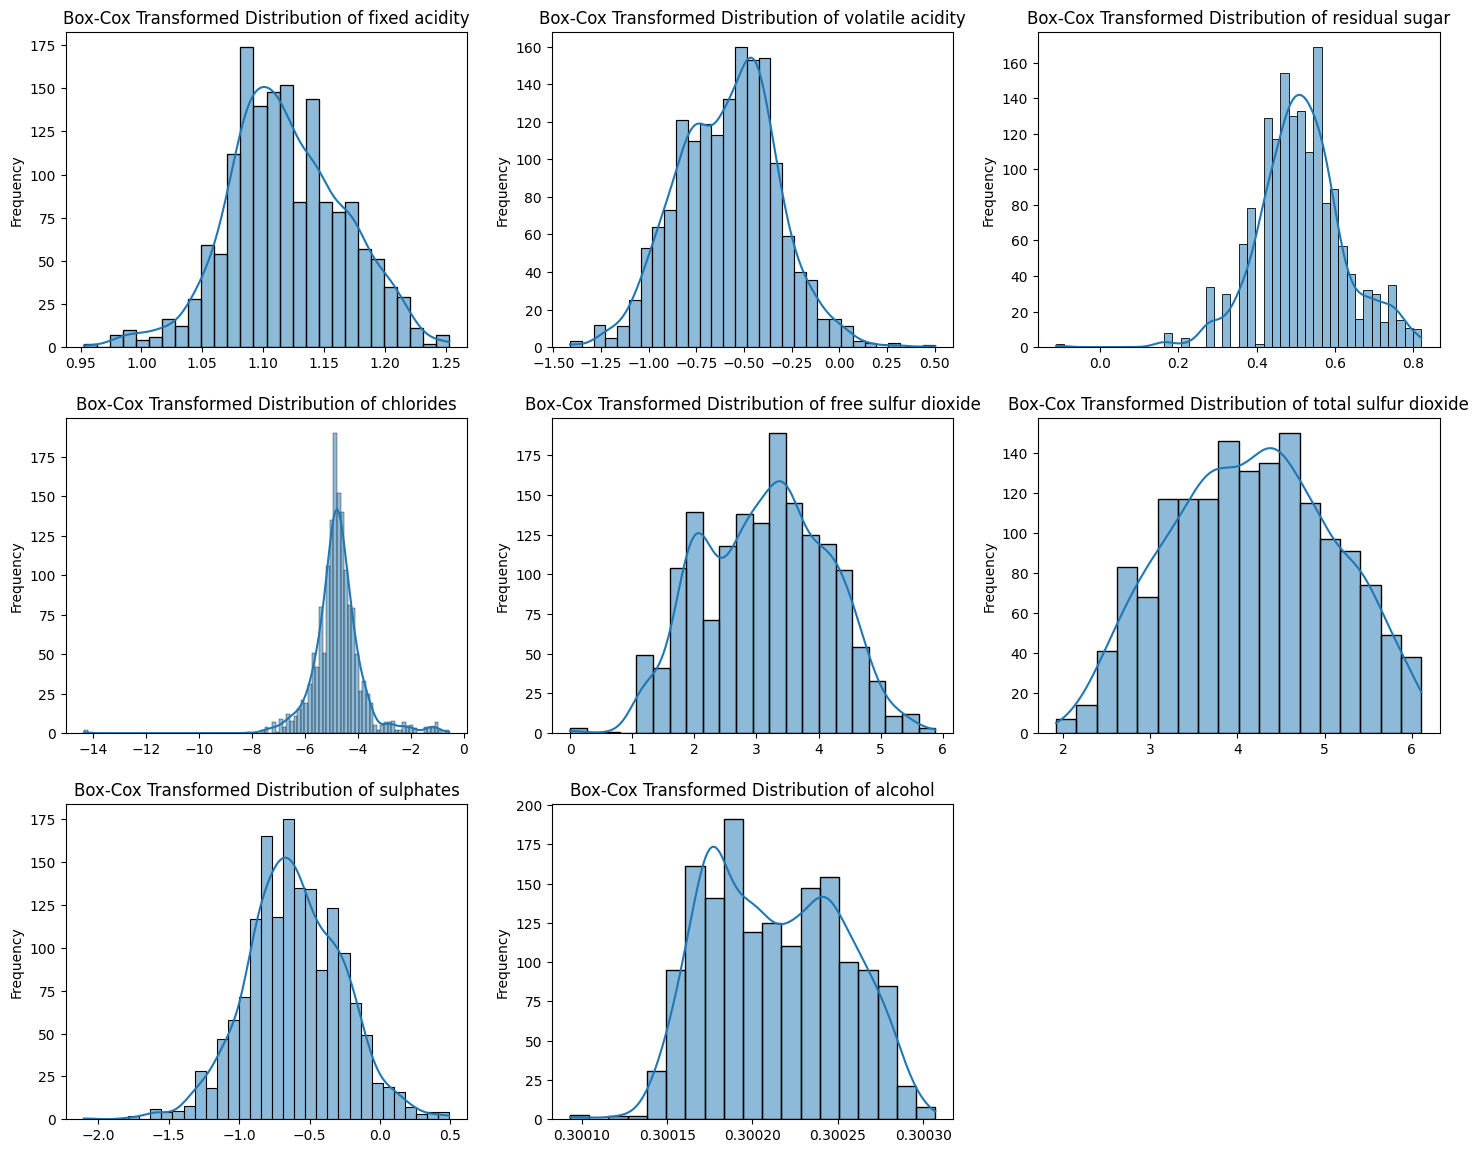

In [19]:
transformed_columns = {}
for column in skewed_columns:
    transformed_columns[f'{column}_boxcox'], _ = boxcox(df[column])

transformed_df = pd.DataFrame(transformed_columns)

fig, axes = plt.subplots(3, 3, figsize=(15, 12))
fig.tight_layout(pad=3.0)

for i, column in enumerate(skewed_columns):
    row, col = divmod(i, 3) 
    sns.histplot(transformed_df[f'{column}_boxcox'], kde=True, ax=axes[row, col])
    axes[row, col].set_title(f"Box-Cox Transformed Distribution of {column}")
    axes[row, col].set_xlabel("")
    axes[row, col].set_ylabel("Frequency")

for j in range(len(skewed_columns), 9):
    fig.delaxes(axes[j // 3, j % 3])

plt.show()

In [20]:
for column in skewed_columns:
    df[column], _ = boxcox(df[column])

df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,1.098022,-0.331666,0.00,0.451419,-4.922816,2.883222,4.054288,0.9978,3.51,-0.799278,0.300172,5
1,1.111423,-0.124520,0.00,0.575361,-4.141924,4.132563,4.969184,0.9968,3.20,-0.475814,0.300194,5
2,1.111423,-0.259466,0.04,0.532241,-4.327579,3.337304,4.673025,0.9970,3.26,-0.545194,0.300194,5
3,1.191699,-0.990201,0.56,0.451419,-4.966043,3.526587,4.817063,0.9980,3.16,-0.735813,0.300194,6
4,1.098022,-0.331666,0.00,0.451419,-4.922816,2.883222,4.054288,0.9978,3.51,-0.799278,0.300172,5


## Correlation analysis

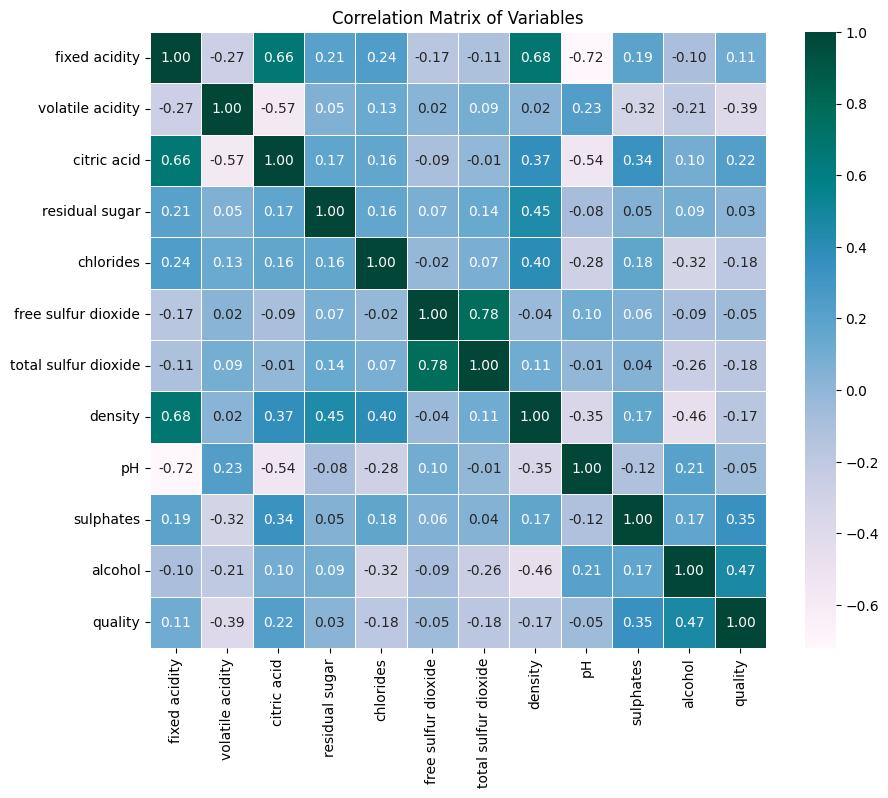

In [21]:
correlation_matrix = df.corr()

plt.figure(figsize=(10, 8))

sns.heatmap(correlation_matrix, annot=True, cmap="PuBuGn", fmt=".2f", square=True, linewidths=0.5)
plt.title("Correlation Matrix of Variables")
plt.show()

# Our target variable is a ordinal categorical variable and so we can include it here. 

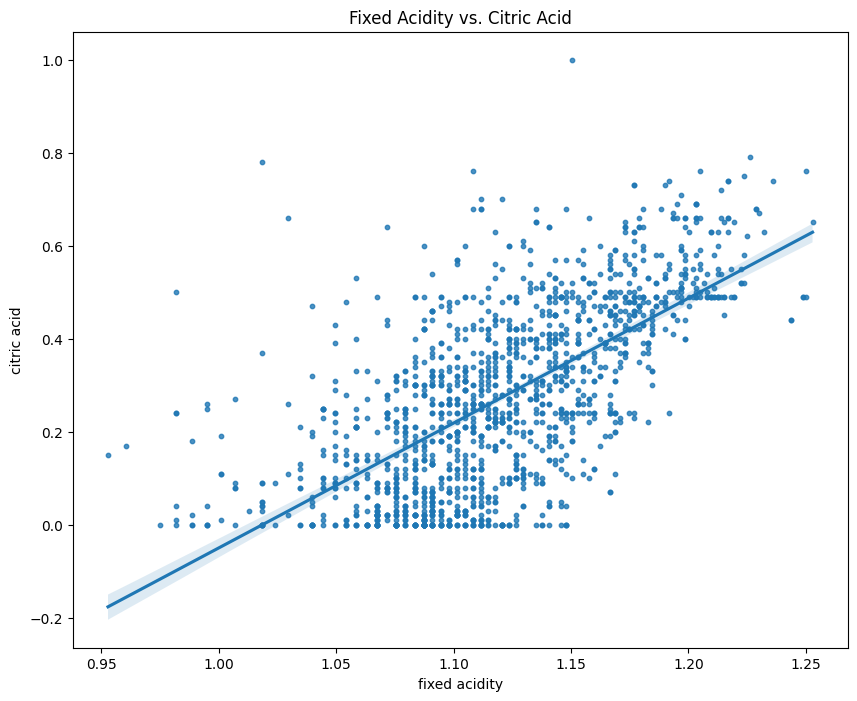

In [22]:
plt.figure(figsize=(10, 8))
sns.regplot(x='fixed acidity', y='citric acid', data=df, scatter_kws={'s':10})
plt.title('Fixed Acidity vs. Citric Acid')
plt.show()

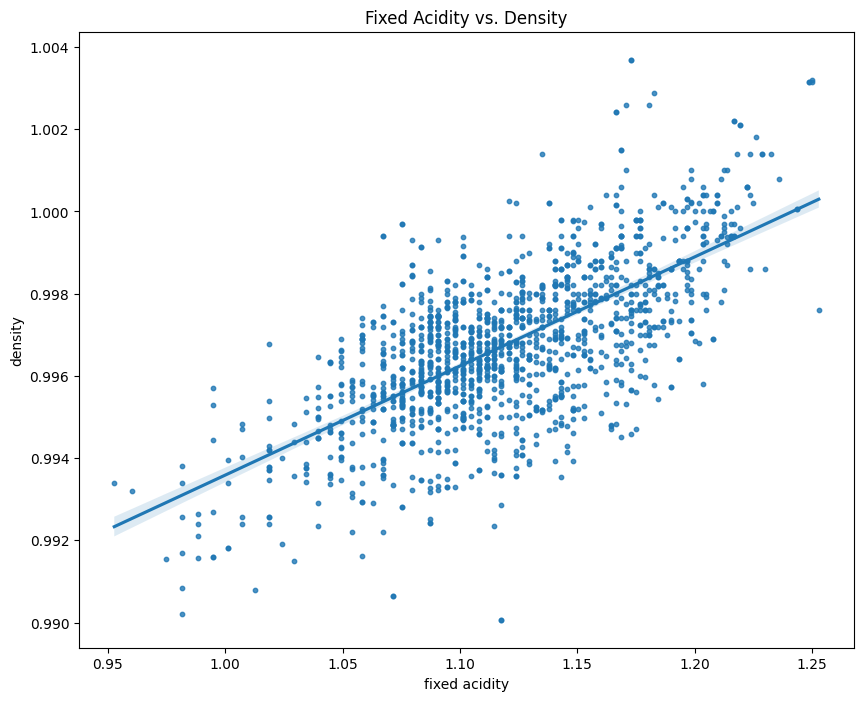

In [23]:
plt.figure(figsize=(10, 8))
sns.regplot(x='fixed acidity', y='density', data=df, scatter_kws={'s':10})
plt.title('Fixed Acidity vs. Density')
plt.show()

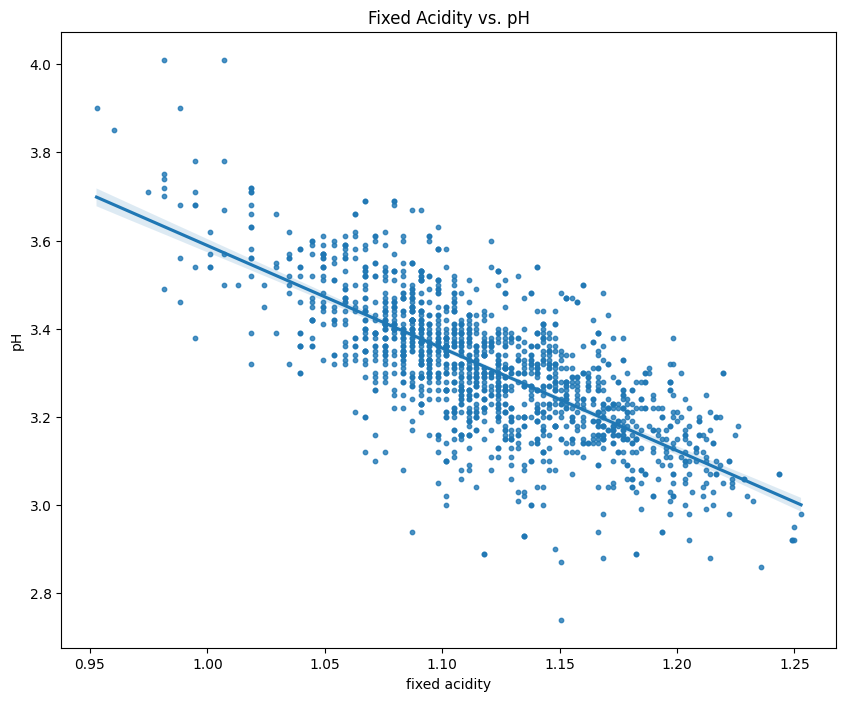

In [24]:
plt.figure(figsize=(10, 8))
sns.regplot(x='fixed acidity', y='pH', data=df, scatter_kws={'s':10})
plt.title('Fixed Acidity vs. pH')
plt.show()

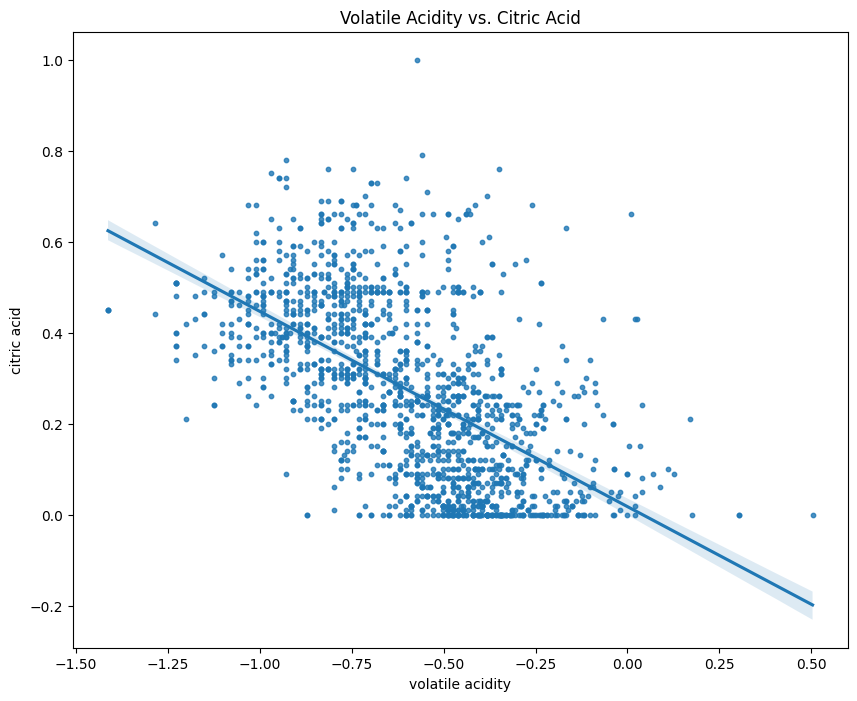

In [25]:
plt.figure(figsize=(10, 8))
sns.regplot(x='volatile acidity', y='citric acid', data=df, scatter_kws={'s':10})
plt.title('Volatile Acidity vs. Citric Acid')
plt.show()

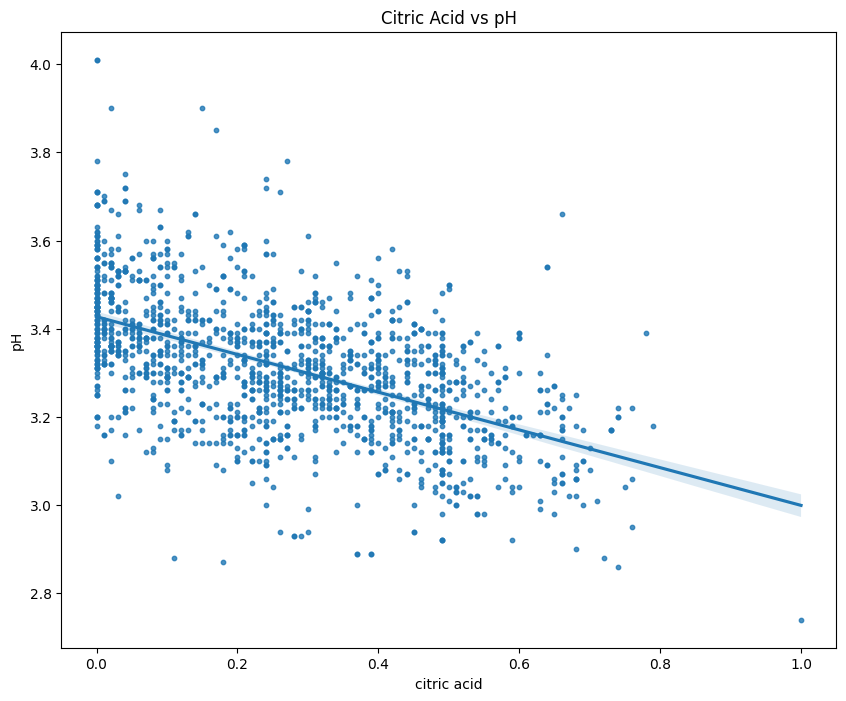

In [26]:
plt.figure(figsize=(10, 8))
sns.regplot(x='citric acid', y='pH', data=df, scatter_kws={'s':10})
plt.title('Citric Acid vs pH')
plt.show()

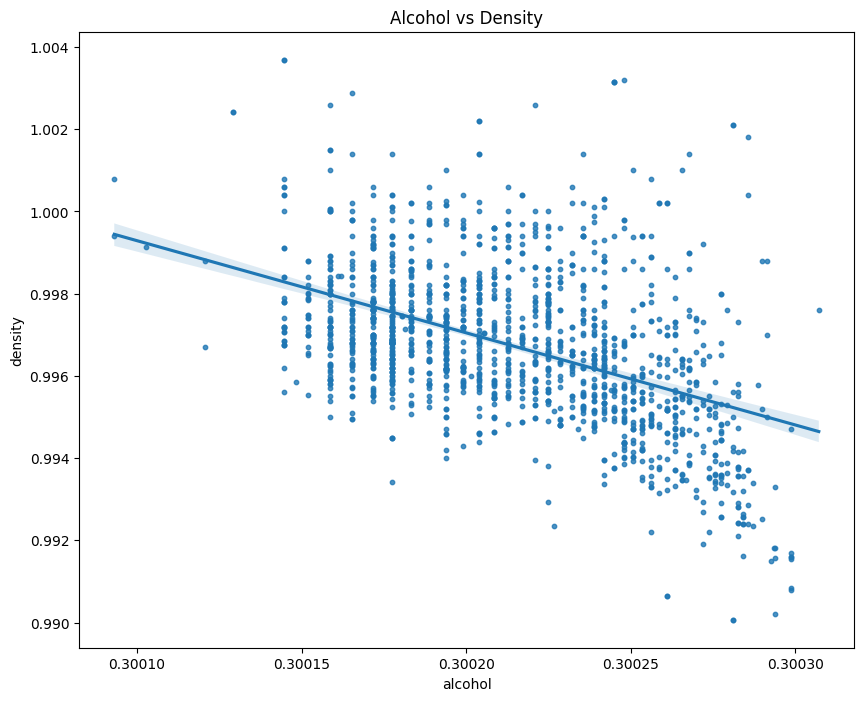

In [27]:
plt.figure(figsize=(10, 8))
sns.regplot(x='alcohol', y='density', data=df, scatter_kws={'s':10})
plt.title('Alcohol vs Density')
plt.show()

After normalizing and removing outliers, I identified the following correlations among features, indicating potential multicollinearity. To address this, I focus on creating interaction terms and selectively removing variables to retain the most predictive and independent features.

Given the correlations:
- **Density** and **pH** are removed due to their high correlations with other critical features:
  - **Density** is correlated with both **fixed acidity** (0.68) and **alcohol** (-0.46), and it’s less directly relevant to wine acidity profiles than **fixed acidity**.
  - **pH** has strong correlations with **fixed acidity** (-0.72) and **citric acid** (-0.54), making it redundant given our use of these acidity measures.

To capture complex relationships without redundancy, we create interaction terms such as **fixed acidity × pH** and **fixed acidity × citric acid**. By removing **density** and **pH**, I simplify our feature set, reduce redundancy, and retain the most informative features for modeling.

## Analyzing our target variable & it's distribution

In [28]:
quality_counts = df['quality'].value_counts(normalize=True) * 100
quality_counts = quality_counts.sort_index()
quality_counts = quality_counts.round(2)
quality_counts

quality
3     0.63
4     3.33
5    42.52
6    40.00
7    12.39
8     1.13
Name: proportion, dtype: float64

In [29]:
quality_counts = df['quality'].value_counts().sort_index()
quality_counts

quality
3     10
4     53
5    676
6    636
7    197
8     18
Name: count, dtype: int64

To facilitate classification, I converted quality ratings to a binary outcome: wines with scores of 7 or higher were labeled as “good” (1), while those below 7 were labeled as “not good” (0). This reclassification yielded an 86\% to 14\% split, slightly accentuating the imbalance and presenting a unique challenge in ensuring accurate predictions for the minority “good" class. The transformed distribution of the target variable informed the choice of classification metrics and underscored the importance of performance metrics that account for imbalance, like ROC-AUC and precision-recall, throughout model evaluation.

In [30]:
y_binary = (df['quality'] >= 7).astype(int)
y_binary.value_counts(normalize=True) * 100 # imbalanced classes

quality
0    86.477987
1    13.522013
Name: proportion, dtype: float64

# Predictive modeling & Determining Feature Importance

## Setting up model pipeline

In [31]:
X = df.drop('quality', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y_binary, test_size=0.3, random_state=42, stratify=y_binary)

To predict the quality of red wine based on chemical properties, I used six classifiers: Logistic Regression, K-Nearest Neighbors (KNN), Support Vector Classifier (SVC), Stochastic Gradient Descent (SGD), Random Forest, and Gradient Boosting. I tested these models before and after feature engineering to assess the impact of interaction terms and feature reduction on prediction accuracy.

1. **Logistic Regression:** I implemented Logistic Regression using L2 regularization, testing various regularization strengths (alpha values of 0.01, 0.1, 1.0, and 10). This baseline model provides a straightforward way to evaluate linear separability.

2. **K-Nearest Neighbors (KNN):** For this model, I tuned the nearest neighbors parameter with values of 3, 5, 7, and 9. This non-parametric model relies on the proximity of data points, so the tuning focused on balancing bias and variance.

3. **Support Vector Classifier (SVC):** I used SVC with various C values (0.1, 1, and 10) to test both linear and non-linear boundaries by experimenting with RBF, polynomial, and linear kernels. The C parameter balances the trade-off between minimizing training error and improving generalization, where higher values prioritize accuracy on the training data. Additionally, I tuned the gamma parameter to adjust boundary flexibility.

4. **Stochastic Gradient Descent (SGD):** The SGD model was tuned for different alpha values, penalties, and learning rates (constant, optimal, adaptive). Testing these parameters allowed me to balance model adaptability and overfitting potential.

5. **Random Forest:** With the number of trees in the forest set to 50, 100, and 200, I used Random Forest to build an ensemble model. This model’s ability to reduce variance and overfitting through averaging makes it robust for classification tasks.

6. **Gradient Boosting:** Finally, I tested Gradient Boosting with various learning rates (0.05, 0.1, 0.2) and numbers of boosting stages (50, 100, 200). This model, which learns sequentially, was expected to perform well due to its focus on correcting errors in successive trees.

After the initial tests, I introduced interaction terms for highly correlated features, specifically, fixed acidity × pH, fixed acidity × citric acid, and volatile acidity × citric acid, to capture relationships between variables. I then removed redundant features such as density and pH based on their correlation with other features. This feature engineering aimed to improve model accuracy by refining feature interactions while reducing multicollinearity.

In [32]:
classifiers = {
    'Logistic Regression': Pipeline([
        ('scaler', StandardScaler()),
        ('logreg', GridSearchCV(
            LogisticRegression(penalty='l2', solver='liblinear', random_state=42),
            param_grid={'C': [0.01, 0.1, 1.0, 10]},
            cv=5))
    ]),
    'KNN Classifier': Pipeline([
        ('scaler', StandardScaler()),
        ('knn', GridSearchCV(KNeighborsClassifier(), param_grid={'n_neighbors': [3, 5, 7, 9]}, cv=5))
    ]),
    'Support Vector Classifier': Pipeline([
        ('scaler', StandardScaler()),
        ('svc', GridSearchCV(SVC(probability=True, random_state=42), param_grid={
            'C': [0.1, 1, 10],
            'kernel': ['linear', 'rbf', 'poly'],
            'gamma': ['scale', 'auto']
        }, cv=5))
    ]),
    'Stochastic Gradient Descent Classifier': Pipeline([
        ('scaler', StandardScaler()),
        ('sgd', GridSearchCV(SGDClassifier(random_state=42), param_grid={
            'alpha': [1e-4, 1e-3, 1e-2],
            'penalty': ['l2', 'l1', 'elasticnet'],
            'max_iter': [1000, 2000],
            'learning_rate': ['constant', 'optimal', 'adaptive'],
            'eta0': [0.001, 0.01]  # ensures that a nonzero learning rate is applied whenever learning_rate='constant' is used.
        }, cv=5, error_score='raise'))
    ]),
    'Random Forest Classifier': Pipeline([
        ('scaler', StandardScaler()),
        ('rf', GridSearchCV(RandomForestClassifier(random_state=42), param_grid={'n_estimators': [50, 100, 200]}, cv=5))
    ]),
    'Gradient Boosting Classifier': Pipeline([
        ('scaler', StandardScaler()),
        ('gb', GridSearchCV(GradientBoostingClassifier(random_state=42), param_grid={'n_estimators': [50, 100, 200], 'learning_rate': [0.05, 0.1, 0.2]}, cv=5))
    ])
}

## Without adjusting for interactions among features


Training Logistic Regression...
Logistic Regression Prediction Variance: 0.0786

Confusion Matrix for Logistic Regression:
[[398  15]
 [ 38  26]]
Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.91      0.96      0.94       413
           1       0.63      0.41      0.50        64

    accuracy                           0.89       477
   macro avg       0.77      0.68      0.72       477
weighted avg       0.88      0.89      0.88       477

Best hyperparameters for Logistic Regression: {'C': 1.0}


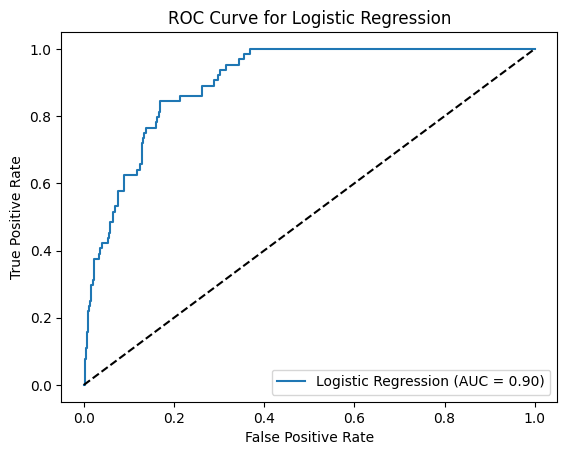


Training KNN Classifier...
KNN Classifier Prediction Variance: 0.1020

Confusion Matrix for KNN Classifier:
[[388  25]
 [ 34  30]]
Classification Report for KNN Classifier:
              precision    recall  f1-score   support

           0       0.92      0.94      0.93       413
           1       0.55      0.47      0.50        64

    accuracy                           0.88       477
   macro avg       0.73      0.70      0.72       477
weighted avg       0.87      0.88      0.87       477

Best hyperparameters for KNN Classifier: {'n_neighbors': 7}


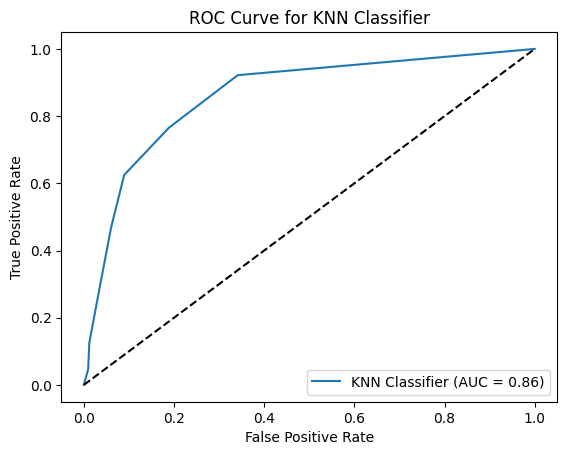


Training Support Vector Classifier...
Support Vector Classifier Prediction Variance: 0.0938

Confusion Matrix for Support Vector Classifier:
[[400  13]
 [ 27  37]]
Classification Report for Support Vector Classifier:
              precision    recall  f1-score   support

           0       0.94      0.97      0.95       413
           1       0.74      0.58      0.65        64

    accuracy                           0.92       477
   macro avg       0.84      0.77      0.80       477
weighted avg       0.91      0.92      0.91       477

Best hyperparameters for Support Vector Classifier: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}


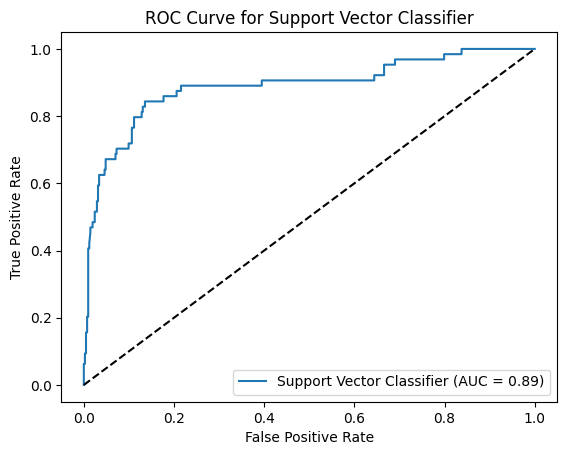


Training Stochastic Gradient Descent Classifier...
Stochastic Gradient Descent Classifier Prediction Variance: 0.0905

Confusion Matrix for Stochastic Gradient Descent Classifier:
[[393  20]
 [ 36  28]]
Classification Report for Stochastic Gradient Descent Classifier:
              precision    recall  f1-score   support

           0       0.92      0.95      0.93       413
           1       0.58      0.44      0.50        64

    accuracy                           0.88       477
   macro avg       0.75      0.69      0.72       477
weighted avg       0.87      0.88      0.88       477

Best hyperparameters for Stochastic Gradient Descent Classifier: {'alpha': 0.001, 'eta0': 0.001, 'learning_rate': 'optimal', 'max_iter': 1000, 'penalty': 'l2'}

Training Random Forest Classifier...
Random Forest Classifier Prediction Variance: 0.0905

Confusion Matrix for Random Forest Classifier:
[[402  11]
 [ 27  37]]
Classification Report for Random Forest Classifier:
              precision    re

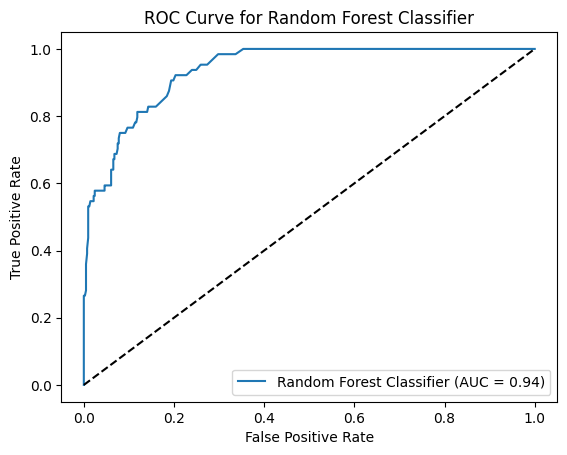

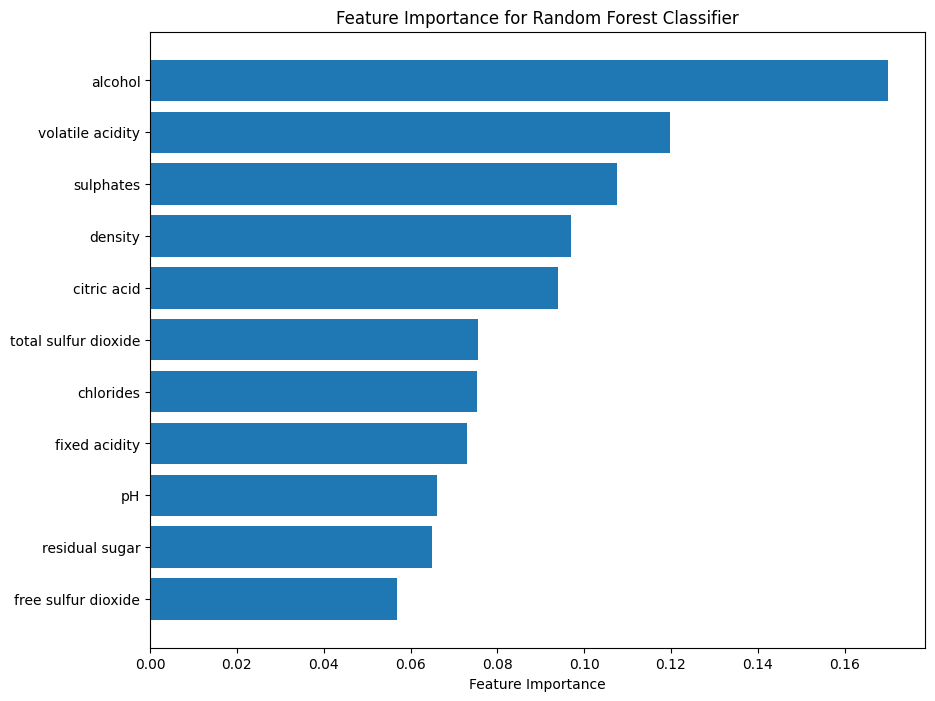


Training Gradient Boosting Classifier...
Gradient Boosting Classifier Prediction Variance: 0.0922

Confusion Matrix for Gradient Boosting Classifier:
[[399  14]
 [ 29  35]]
Classification Report for Gradient Boosting Classifier:
              precision    recall  f1-score   support

           0       0.93      0.97      0.95       413
           1       0.71      0.55      0.62        64

    accuracy                           0.91       477
   macro avg       0.82      0.76      0.78       477
weighted avg       0.90      0.91      0.90       477

Best hyperparameters for Gradient Boosting Classifier: {'learning_rate': 0.2, 'n_estimators': 100}


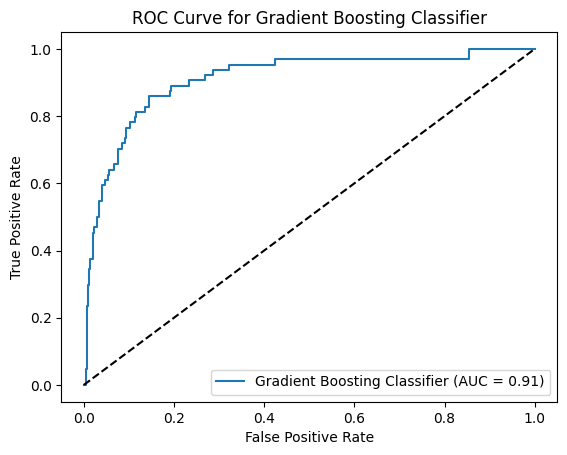

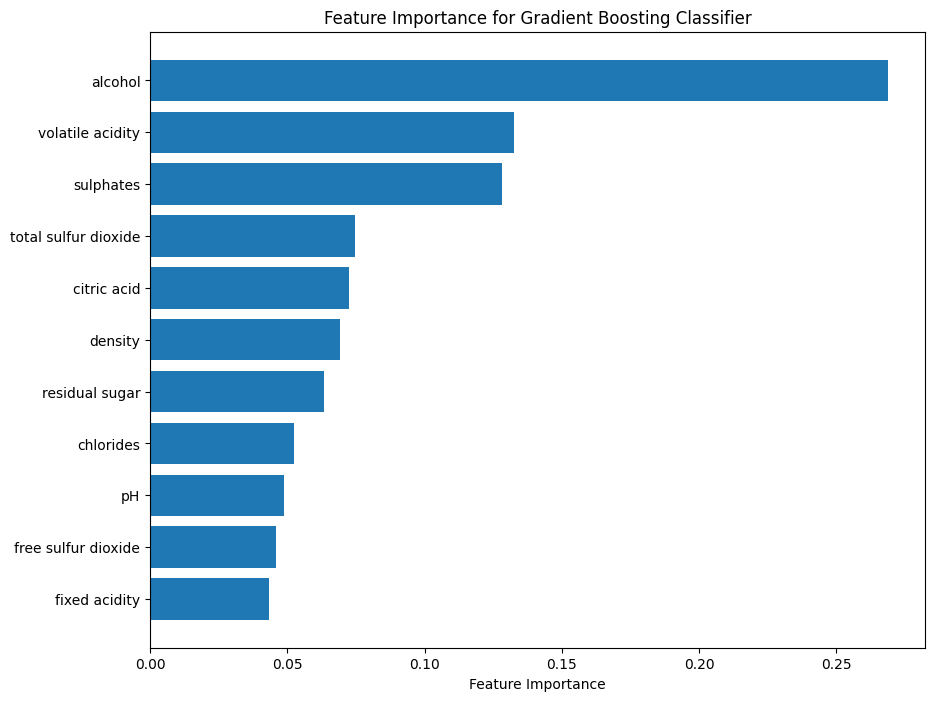

In [33]:
for classifier_name, classifier_pipeline in classifiers.items():
    print(f"\nTraining {classifier_name}...")
    classifier_pipeline.fit(X_train, y_train)
    
    y_pred = classifier_pipeline.predict(X_test)
    prediction_variance = np.var(y_pred)
    print(f"{classifier_name} Prediction Variance: {prediction_variance:.4f}")
    
    print(f"\nConfusion Matrix for {classifier_name}:\n{confusion_matrix(y_test, y_pred)}")
    print(f"Classification Report for {classifier_name}:\n{classification_report(y_test, y_pred)}")
    
    for step_name, step in classifier_pipeline.named_steps.items():
        if isinstance(step, GridSearchCV):
            print(f"Best hyperparameters for {classifier_name}: {step.best_params_}")
    
    if hasattr(classifier_pipeline, "predict_proba"):
        y_proba = classifier_pipeline.predict_proba(X_test)[:, 1]
        auc_score = roc_auc_score(y_test, y_proba)
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        
        plt.figure()
        plt.plot(fpr, tpr, label=f'{classifier_name} (AUC = {auc_score:.2f})')
        plt.plot([0, 1], [0, 1], 'k--') 
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve for {classifier_name}')
        plt.legend(loc='lower right')
        plt.show()

    if hasattr(classifier_pipeline.named_steps[step_name].best_estimator_, "feature_importances_"):
        feature_importances = classifier_pipeline.named_steps[step_name].best_estimator_.feature_importances_
        sorted_idx = feature_importances.argsort()
        plt.figure(figsize=(10, 8))
        plt.barh(range(len(sorted_idx)), feature_importances[sorted_idx], align="center")
        plt.yticks(range(len(sorted_idx)), [X.columns[i] for i in sorted_idx])
        plt.xlabel("Feature Importance")
        plt.title(f"Feature Importance for {classifier_name}")
        plt.show()

## Adjusting for interactions among features

In [34]:
df_fe = df.copy()

# create interaction features based on correlations
df_fe['fixed_acidity_ph_interaction'] = df_fe['fixed acidity'] * df_fe['pH']
df_fe['fixed_acidity_citric_interaction'] = df_fe['fixed acidity'] * df_fe['citric acid']
df_fe['volatile_acidity_citric_interaction'] = df_fe['volatile acidity'] * df_fe['citric acid']

# drop one feature from each highly correlated pair
df_fe = df_fe.drop(columns=['density', 'pH'])


Training Logistic Regression with Feature Engineering...
Logistic Regression Prediction Variance: 0.0786

Confusion Matrix for Logistic Regression with Feature Engineering:
[[397  16]
 [ 39  25]]
Classification Report for Logistic Regression with Feature Engineering:
              precision    recall  f1-score   support

           0       0.91      0.96      0.94       413
           1       0.61      0.39      0.48        64

    accuracy                           0.88       477
   macro avg       0.76      0.68      0.71       477
weighted avg       0.87      0.88      0.87       477

Best hyperparameters for Logistic Regression: {'C': 1.0}


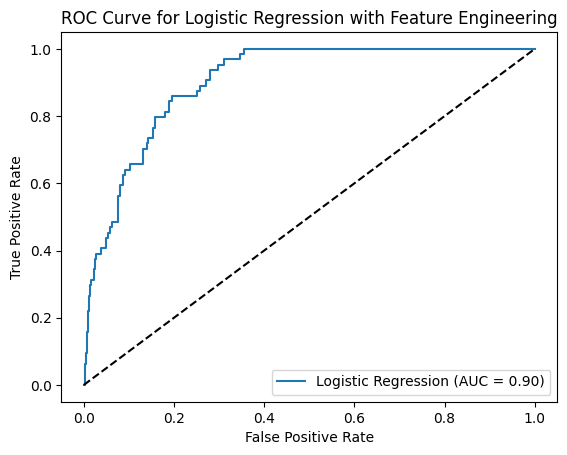


Training KNN Classifier with Feature Engineering...
KNN Classifier Prediction Variance: 0.1192

Confusion Matrix for KNN Classifier with Feature Engineering:
[[382  31]
 [ 29  35]]
Classification Report for KNN Classifier with Feature Engineering:
              precision    recall  f1-score   support

           0       0.93      0.92      0.93       413
           1       0.53      0.55      0.54        64

    accuracy                           0.87       477
   macro avg       0.73      0.74      0.73       477
weighted avg       0.88      0.87      0.88       477

Best hyperparameters for KNN Classifier: {'n_neighbors': 5}


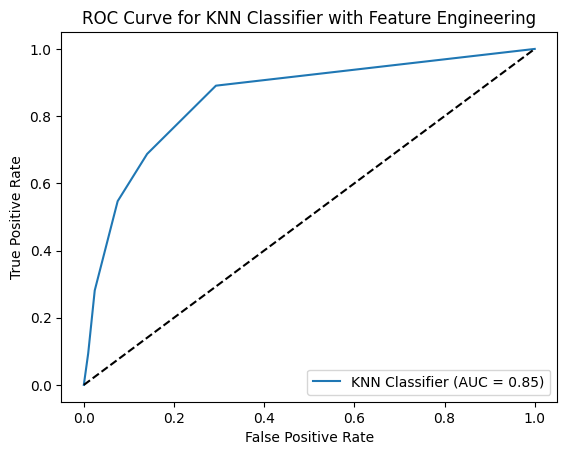


Training Support Vector Classifier with Feature Engineering...
Support Vector Classifier Prediction Variance: 0.0922

Confusion Matrix for Support Vector Classifier with Feature Engineering:
[[400  13]
 [ 28  36]]
Classification Report for Support Vector Classifier with Feature Engineering:
              precision    recall  f1-score   support

           0       0.93      0.97      0.95       413
           1       0.73      0.56      0.64        64

    accuracy                           0.91       477
   macro avg       0.83      0.77      0.79       477
weighted avg       0.91      0.91      0.91       477

Best hyperparameters for Support Vector Classifier: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}


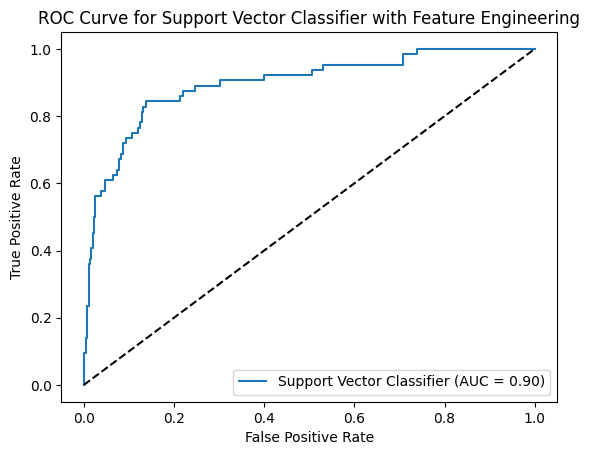


Training Stochastic Gradient Descent Classifier with Feature Engineering...
Stochastic Gradient Descent Classifier Prediction Variance: 0.0515

Confusion Matrix for Stochastic Gradient Descent Classifier with Feature Engineering:
[[402  11]
 [ 49  15]]
Classification Report for Stochastic Gradient Descent Classifier with Feature Engineering:
              precision    recall  f1-score   support

           0       0.89      0.97      0.93       413
           1       0.58      0.23      0.33        64

    accuracy                           0.87       477
   macro avg       0.73      0.60      0.63       477
weighted avg       0.85      0.87      0.85       477

Best hyperparameters for Stochastic Gradient Descent Classifier: {'alpha': 0.001, 'eta0': 0.01, 'learning_rate': 'constant', 'max_iter': 1000, 'penalty': 'elasticnet'}

Training Random Forest Classifier with Feature Engineering...
Random Forest Classifier Prediction Variance: 0.0871

Confusion Matrix for Random Forest Classifi

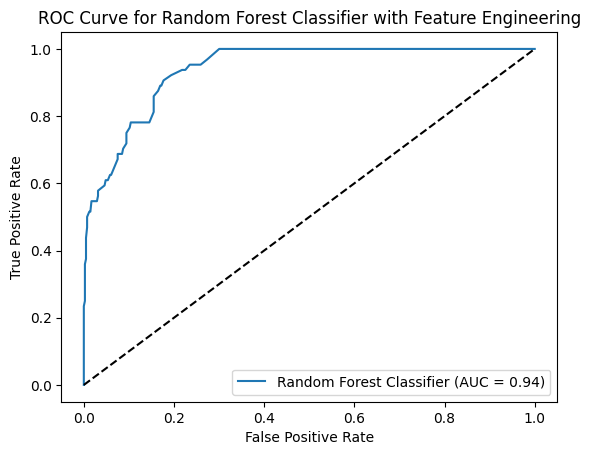

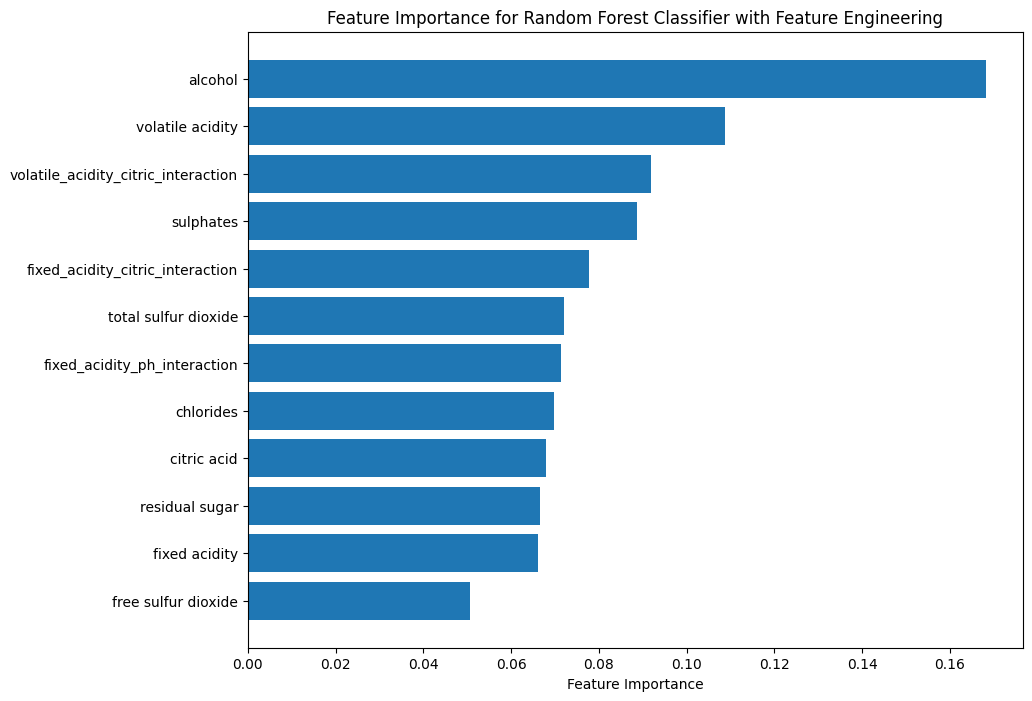


Training Gradient Boosting Classifier with Feature Engineering...
Gradient Boosting Classifier Prediction Variance: 0.1052

Confusion Matrix for Gradient Boosting Classifier with Feature Engineering:
[[393  20]
 [ 27  37]]
Classification Report for Gradient Boosting Classifier with Feature Engineering:
              precision    recall  f1-score   support

           0       0.94      0.95      0.94       413
           1       0.65      0.58      0.61        64

    accuracy                           0.90       477
   macro avg       0.79      0.76      0.78       477
weighted avg       0.90      0.90      0.90       477

Best hyperparameters for Gradient Boosting Classifier: {'learning_rate': 0.2, 'n_estimators': 200}


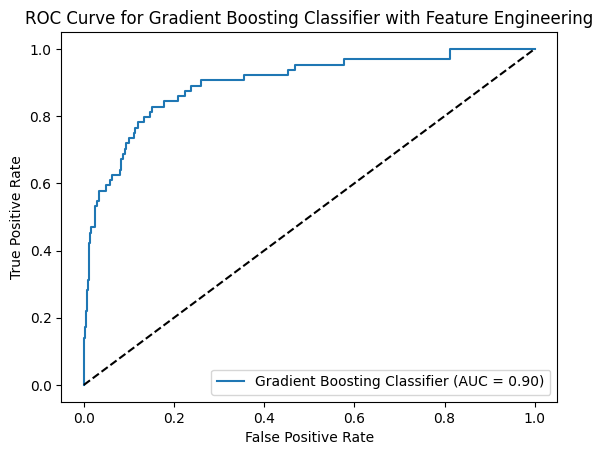

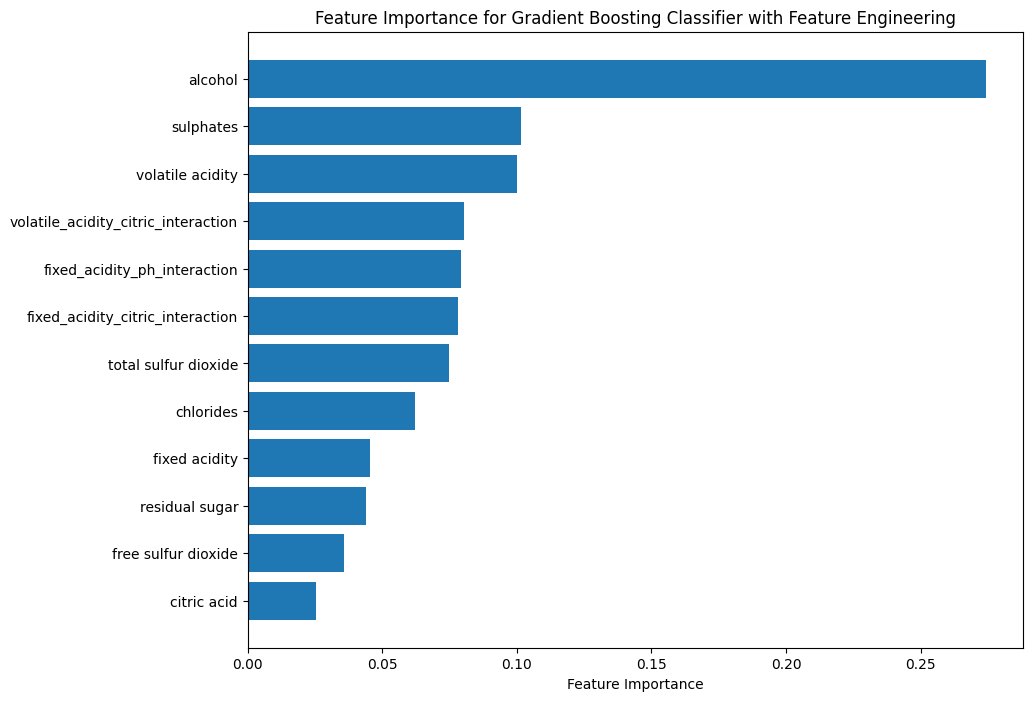

In [35]:
X_fe = df_fe.drop(columns=['quality'])

X_train, X_test, y_train, y_test = train_test_split(X_fe, y_binary, test_size=0.3, random_state=42, stratify=y_binary)

for classifier_name, classifier_pipeline in classifiers.items():
    print(f"\nTraining {classifier_name} with Feature Engineering...")
    classifier_pipeline.fit(X_train, y_train)
    
    y_pred = classifier_pipeline.predict(X_test)
    prediction_variance = np.var(y_pred)
    print(f"{classifier_name} Prediction Variance: {prediction_variance:.4f}")
    
    print(f"\nConfusion Matrix for {classifier_name} with Feature Engineering:\n{confusion_matrix(y_test, y_pred)}")
    print(f"Classification Report for {classifier_name} with Feature Engineering:\n{classification_report(y_test, y_pred)}")
    
    for step_name, step in classifier_pipeline.named_steps.items():
        if isinstance(step, GridSearchCV):
            print(f"Best hyperparameters for {classifier_name}: {step.best_params_}")
    
    if hasattr(classifier_pipeline, "predict_proba"):
        y_proba = classifier_pipeline.predict_proba(X_test)[:, 1]
        
        auc_score = roc_auc_score(y_test, y_proba)
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        
        plt.figure()
        plt.plot(fpr, tpr, label=f'{classifier_name} (AUC = {auc_score:.2f})')
        plt.plot([0, 1], [0, 1], 'k--') 
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve for {classifier_name} with Feature Engineering')
        plt.legend(loc='lower right')
        plt.show()

    if hasattr(classifier_pipeline.named_steps[step_name].best_estimator_, "feature_importances_"):
        feature_importances = classifier_pipeline.named_steps[step_name].best_estimator_.feature_importances_
        sorted_idx = feature_importances.argsort()
        plt.figure(figsize=(10, 8))
        plt.barh(range(len(sorted_idx)), feature_importances[sorted_idx], align="center")
        plt.yticks(range(len(sorted_idx)), [X_fe.columns[i] for i in sorted_idx])
        plt.xlabel("Feature Importance")
        plt.title(f"Feature Importance for {classifier_name} with Feature Engineering")
        plt.show()

# Overall Performance Summary

### 1) Results Before Feature Engineering

- **Logistic Regression** achieved an accuracy of 89% with a best $C$ value of 1.0. While it performed well with the majority class, it struggled with recall for the minority class (41%).

- **KNN** achieved 88% accuracy with `n_neighbors=7`, showing slightly better recall for the minority class at 47%. The model exhibited higher variance due to sensitivity to nearby data points.

- **SVC** with an RBF kernel ($C=10$, $\gamma=scale$) was the top performer before feature engineering, with 92% accuracy and 58% recall for the minority class. The ROC-AUC curve showed effective class separation, showcasing SVC's capacity for non-linear decision boundaries.

- **SGD** attained 88% accuracy with $\alpha=0.001$ and $l2$ penalty, performing moderately well on minority recall (44%) but showing variability due to sensitivity to parameter selection.

- **Random Forest** achieved 92% accuracy with n_estimators=200, maintaining low prediction variance and a minority class recall of 58%. Alcohol emerged as the top predictor in Random Forest, with volatile acidity and sulphates as close runner-ups.

- **Gradient Boosting** also performed well, achieving 91% accuracy and 55% recall for the minority class with learning_rate=0.2 and n_estimators=100. Alcohol was again the strongest predictor, followed closely by volatile acidity and sulphates, demonstrating Gradient Boosting's ability to capture key chemical indicators of wine quality.

### 2) Results After Feature Engineering

Feature engineering, which included interaction terms and the removal of some redundant features, had mixed effects across models:

- **Logistic Regression** experienced minimal change, with a slight decrease in overall accuracy to 88% and minority recall dropping to 39%, suggesting limited benefit from the interaction terms.

- **KNN** with `n_neighbors=5` showed increased prediction variance but maintained 87% accuracy, with a minor improvement in minority recall to 55%.

- **SVC**  maintained high accuracy at 91% with $C=10$ and $\gamma=scale$, with a slight drop in minority recall to 56%. Interaction terms marginally enhanced its ROC-AUC score.

- **SGD** exhibited more instability post-feature engineering, with minority recall decreasing to 23%, indicating that the added complexity from interaction terms may have overwhelmed the model's capacity.

- **Random Forest** retained 92% accuracy and showed a slightly reduced minority recall of 55%. With feature engineering, alcohol remained the top predictor, while volatile acidity and the interaction of volatile acidity and citric acid became the next most important features, indicating enhanced feature capture of chemical interactions.

- **Gradient Boosting**  maintained 90% accuracy, with a small reduction in AUC-ROC. Feature engineering influenced its feature ranking, where alcohol, sulphates, and volatile acidity emerged as the most significant predictors.

Random Forest and SVC emerged as the best-performing models in terms of testing error and accuracy. Random Forest achieved the highest accuracy both before feature engineering (92%) and sustained this high level of accuracy after feature engineering. This result reflects Random Forest's robustness in capturing complex patterns relevant to wine quality prediction, even with adjusted feature interactions.

SVC also demonstrated strong performance prior to feature engineering, underscoring its effectiveness in establishing flexible decision boundaries. Although feature engineering improved its ROC-AUC, accuracy and recall decreased slightly.

Gradient Boosting remained competitive, maintaining high accuracy and stability across feature engineering phases. However, it did not reach the level of accuracy achieved by Random Forest, underscoring Random Forest's robustness for this dataset.

# Conclusion
This study demonstrated that ensemble methods, especially Random Forest, are highly effective for predicting wine quality based solely on chemical properties. The systematic approach to feature engineering and extensive hyperparameter tuning proved essential for optimizing each model's performance, especially in complex datasets with non-linear relationships.
Random Forest's performance—achieving and sustaining the highest accuracy—highlights its adaptability and reliability in this predictive task. These findings offer a data-driven framework for wine producers, illustrating that even without contextual features like branding, grape variety, or pricing, chemical properties alone can yield reliable predictions for quality assessment.